# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Открываем файл с данными и изучаем общую информацию

In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd


In [3]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


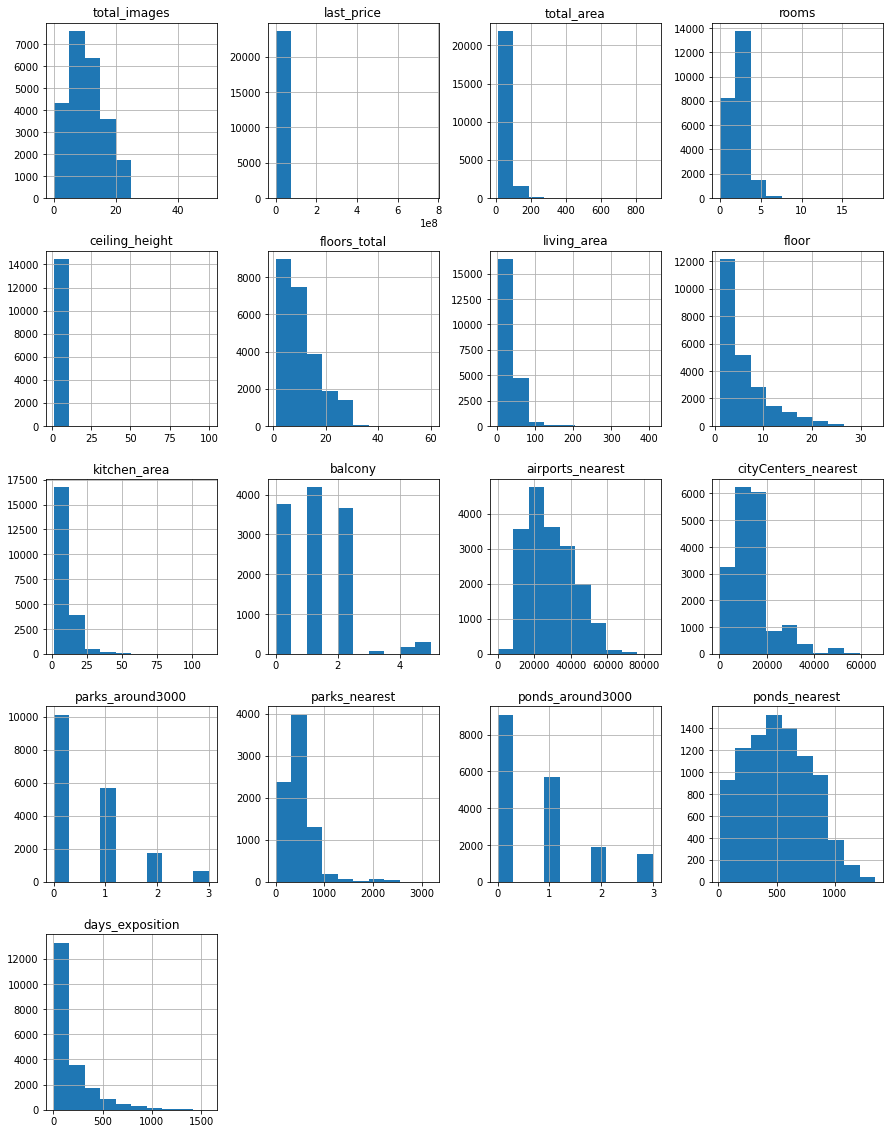

In [5]:
data.hist(figsize=(15, 20));
#строим гистограмму для всех числовых столбцов таблицы

     Ознакомившись с данными,предоставленными для исследования на данном этапе, можем сделать вывод, что не все столбцы имеют подходящий тип данных, например first_day_exposition необходимо перевести в формат datetime,balcony,floors_total, parks_nearest,ponds_nearest в int, cтолбец is_apartment в bool.
     Во многих столбцах также наблюдаются пропуски в данных,которые могут помешать дальнейшему исследованию.

### Выполните предобработку данных

#### Находим пропущенные значения в столбцах

In [6]:
data.isna().sum() 


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
# check
# пропущенные значения бары

def pass_value_barh(dfg):
    try:
        (
            (dfg.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('Распределение пропущенных значений' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')
        

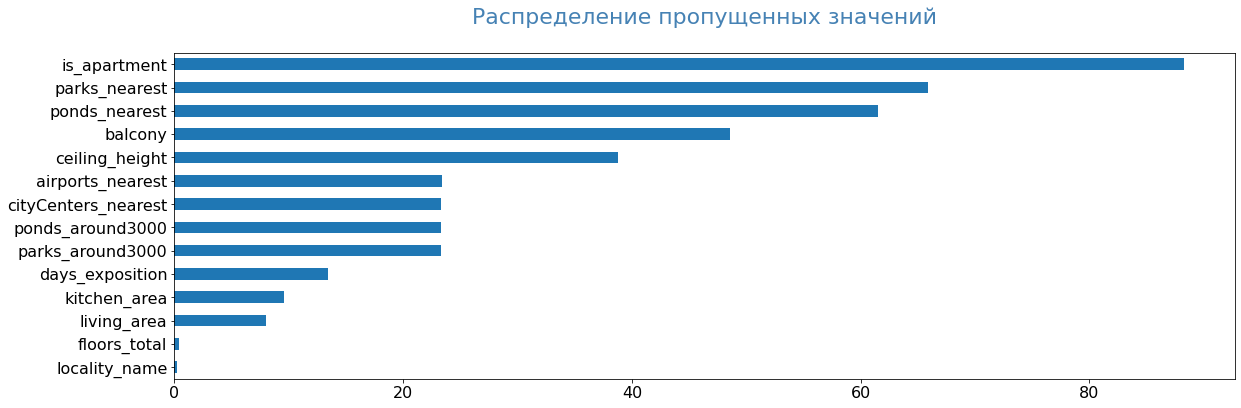

In [8]:
pass_value_barh(data)

#### Заменяем пропущенные значения
Пропуски количества балконов,предполагаем,что если количество не указано,то их 0.
Пропуски в столбце аппартаменты на False.


In [9]:
data['balcony'] = data['balcony'].fillna(0) 
data['is_apartment'] = data['is_apartment'].fillna(False) 


Пропуски столбца balcony говорят о возможном отсутствии балкона в квартире.
Отсутствие значений в столбце булевого типо is_apartment скорее всего говорит о том,что данный объект не является аппартаментами.

In [10]:
print(data['ceiling_height'].unique)


<bound method Series.unique of 0        2.70
1         NaN
2         NaN
3         NaN
4        3.03
         ... 
23694    3.70
23695     NaN
23696     NaN
23697    3.00
23698    2.50
Name: ceiling_height, Length: 23699, dtype: float64>


In [11]:
print(data.query('locality_name == "Санкт-Петербург" & cityCenters_nearest <= 5000 & ceiling_height.isna()'))


       total_images  last_price  total_area first_day_exposition  rooms  \
24                8   6500000.0        97.2  2015-10-31T00:00:00      2   
35                6  15500000.0       149.0  2017-06-26T00:00:00      5   
61               18   7990000.0        74.0  2017-08-24T00:00:00      2   
99               32   9600000.0        90.0  2017-09-26T00:00:00      4   
138               8   4800000.0        40.0  2017-11-18T00:00:00      2   
...             ...         ...         ...                  ...    ...   
23559            20  13800000.0       108.6  2016-09-12T00:00:00      3   
23560             7   5700000.0        34.5  2017-10-19T00:00:00      1   
23590             0  21187872.0       123.3  2017-04-25T00:00:00      3   
23609             7   7280000.0        64.3  2018-07-20T00:00:00      2   
23665            11   4250000.0        47.0  2016-05-20T00:00:00      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
24                NaN

In [12]:
data_ceil = data.query('locality_name == "Санкт-Петербург" & cityCenters_nearest <= 5000 & ceiling_height.isna()')
data_ceil.loc[data_ceil['ceiling_height'] == 'NAN', 'ceiling_height'] = 3.5


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [13]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.5)
print(data['ceiling_height'].value_counts().head(20))

2.50    12710
2.60     1646
2.70     1574
3.00     1112
2.80      993
2.55      980
2.75      910
2.65      676
3.20      277
3.10      203
2.90      164
3.30      141
2.56      139
3.50      130
2.57      103
2.85      101
3.40       92
2.54       83
2.64       81
2.52       79
Name: ceiling_height, dtype: int64


In [14]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски в столбце ceiling_height заменим значениями 2.5м и 3.5м в зависимости от места рассположения жилой недвижимости.Для объектов в историческом центре Санкт-Петербурга примем значение 3.5м, для остальных районов 2.5м.

In [15]:
data['locality_name'] = data['locality_name'].fillna('unknown') #заменяем пропуски в столбце название населенного пункта на unknown

       Для заполнения пропусков в столбцах living_area и kitchen_area введем дополнительные коэффициенты, которые посчитаем как среднее значение соотношения living_area/kitchen_area к total_area.
       Для этого считаем соотношение жилой площади к общей площади по каждой строке датафрейма(k_liv) и находим среднее значение коэффициента,округляем до 2-х знаков после запятой. По такому же принципу рассчитываем коэффициент k_kitch.


In [16]:
k_liv = data['living_area'] / data['total_area'] 
k_liv_mean =round(k_liv.mean(), 2)
print(k_liv_mean)

0.56


In [17]:
k_kitch = data['kitchen_area'] / data['total_area'] #считаем соотношение площади кухни к общей площади по каждой строке датафрейма
k_kitch_mean =round(k_kitch.mean(), 2) #находим среднее значение коэффициента,округляем до 2-х знаков после запятой
print(k_kitch_mean)

0.19


In [18]:
#data['living_area'] = data['living_area'].fillna(data['total_area'] * k_liv_mean) 
#data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] * k_kitch_mean)

После замены пропусков в столбцах жилая площадь и площадь кухни проверим на корректность значений всех наших площадей, т.к. есть коридоры, сан.узлы, балконы — на них отводим условные 10% площади
        

In [19]:
data_area = data.query('total_area * 0.9 <= living_area + kitchen_area')
print(data_area)


       total_images  last_price  total_area first_day_exposition  rooms  \
41               16   7900000.0        74.0  2016-05-04T00:00:00      3   
171               6   3800000.0        49.0  2019-02-22T00:00:00      2   
184               7   2600000.0        30.2  2018-02-14T00:00:00      1   
220               8   3890000.0        37.0  2018-07-09T00:00:00      1   
319              19   4850000.0        59.7  2015-03-19T00:00:00      3   
...             ...         ...         ...                  ...    ...   
23216            15  10150000.0       114.0  2015-01-21T00:00:00      4   
23297            10   1850000.0        48.2  2019-03-13T00:00:00      2   
23328            12   4299000.0        54.0  2016-11-25T00:00:00      2   
23521            13   8500000.0        65.0  2018-11-01T00:00:00      2   
23680            14   5000000.0        59.0  2019-04-04T00:00:00      3   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
41               2.50

In [20]:
#data_area['living_area'] = data_area['living_area'].fillna(data_area['living_area'] * k_liv)


In [21]:
#data.living_area.where(data.total_area*0.9 >= data.living_area+data.kitchen_area, other= data.living_area * k_liv)

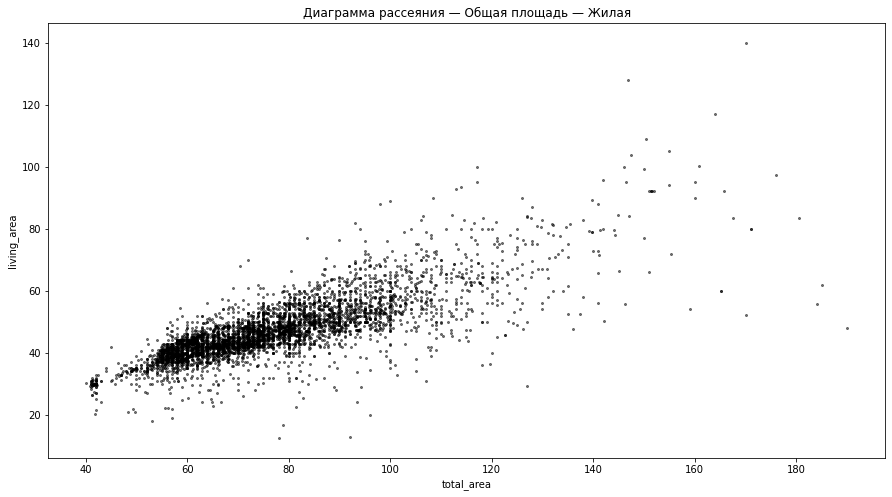

In [22]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

Проанализировав замену пропусков синтетическими значениями в living_area и kitchen_area с помощью диаграммы рассеяния, приходим к выводу,что данные пропуски целесообразнее оставить без измененений.

   Рассмотрим столбец floors_total и увидим,что в нем 86 пропусков из 23698, что составляет примерно 0,36%  и не является критичным, оставим без изменений. Далее проведем проверку на корректность данных, сравним значения floor и floors_total.

In [23]:
(data.query('floor > floors_total'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Отсутствие данных в столбцах:
living_area, kitchen_area скорее всего обусловлено отсутствием этих данных у продавцов или неполнотой поданых сведений.
Данные floors_total скорее свего также не указал продавец. 


In [24]:
data.isna().sum() #проверяем количество пропущенных значений после произведенных замен

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

По оставшимя столбцам замены не производим,т.к. подходящая логическая замена не найдена, медианные или средние значения врядли будут отражать действительность.

#### Проверяеми меняем типы данных в столбцах, где это необходимо


In [25]:
data.info() #смотрим информацию о типах данных столбцов таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

In [26]:
data['balcony'] = data['balcony'].astype(int)





Типы данных в столбце balcony  изменены с object на int, т.к. данные в этом столбце являются целыми числами.

In [27]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S' )


Изменяем тип данных столбца first_day_exposition на datetime,т.к. в данном столбце отображена дата публикации.

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

#### Изучаем уникальные значения в столбце с названиями и устраняем неявные дубликаты.

In [29]:
print(data['locality_name'].unique()) 

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [30]:
print(data['locality_name'].value_counts()) #находим количество уникальных названий до преобразования

Санкт-Петербург                   15721
посёлок Мурино                      522
посёлок Шушары                      440
Всеволожск                          398
Пушкин                              369
                                  ...  
посёлок Мыза-Ивановка                 1
садовое товарищество Рахья            1
поселок Семиозерье                    1
посёлок городского типа Рябово        1
деревня Тойворово                     1
Name: locality_name, Length: 365, dtype: int64


In [31]:
data['locality_name'] = data['locality_name'].str.lower() #приводим все названия к нижнему регистру

In [32]:
data['locality_name'] = (data['locality_name'].str.replace('ё', 'е')) #заменяем в названиях ё на е

In [33]:
data.duplicated().sum()

0

In [34]:
data['locality_name'] = (data['locality_name'].replace(['поселок городского типа рябово', 'поселок мурино', 'деревня кудрово', 
                                                        'садовое товарищество рахья', 'поселок городского типа мга', 'поселок городского типа рощино',
                                                        'деревня щеглово', 'поселок железнодорожной станции приветнинское', 'поселок городского типа большая ижора',
                                                        'городской поселок лесогорский'], ['поселок рябово', 'мурино', 'кудрово', 'поселок городского типа рахья',
                                                        'городской поселок мга', 'городской поселок рощино', 'поселок щеглово', 'поселок станции приветнинское',
                                                        'городской поселок большая ижора', 'поселок городского типа лесогорский']))                           



#### Проводим проверку,смотрим оставшееся количество уникальных имен

In [35]:
# check
data.locality_name.nunique()

322

      На этапе предобработки данных были заполнены пропуски в следующих столбцах:
    -balcony на 0,предполагаем,что они отсутствуют
    -is_appartment на False,
    -ceiling_height на 2.5 и 3.5 м в зависимости от рассположения объекта недаижимости
    -пропуски в locslity_name изменены на unknown
    -living/kitchen_area заполнены исходя из коэффициентов.
    Также были изменены типы данных в столбцах balcony на int, first_day_exposition на datetime
    Данные проверены на наличие дубликатов, а также выявлены и заменены неявные дубликаты в названиях (locality_name).


### Добавляем в таблицу новые столбцы

Cоздаем столбец price_m^2 со стоимостью квадратного метра

In [36]:
 data['price_m^2'] = round((data['last_price'] / data['total_area']),2) 

In [37]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m^2
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,False,...,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37
1,7,3350000.0,40.40,2018-12-04,1,2.50,11.0,18.60,1,False,...,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.79
2,10,5196000.0,56.00,2015-08-20,2,2.50,5.0,34.30,4,False,...,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71
3,0,64900000.0,159.00,2015-07-24,3,2.50,14.0,NaN,9,False,...,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,...,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00
5,10,2890000.0,30.40,2018-09-10,1,2.50,12.0,14.40,5,False,...,0,городской поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.79
6,6,3700000.0,37.30,2017-11-02,1,2.50,26.0,10.60,6,False,...,1,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.71
7,5,7915000.0,71.60,2019-04-18,2,2.50,24.0,NaN,22,False,...,2,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,110544.69
8,20,2900000.0,33.16,2018-05-23,1,2.50,27.0,15.43,26,False,...,0,мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,87454.76
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,...,2,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,88524.59


In [38]:
data['day_week'] = data['first_day_exposition'].dt.weekday #добавляем столбец day_week с днем недели публикации обьявления


In [39]:
data['month'] =  data['first_day_exposition'].dt.month #добавляем столбец month с месяцем публикации обьявления


In [40]:
data['year'] =  data['first_day_exposition'].dt.year #добавляем столбец year с годом публикации обьявления


In [41]:
data.head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m^2,day_week,month,year
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,False,...,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,3,3,2019
1,7,3350000.0,40.40,2018-12-04,1,2.50,11.0,18.60,1,False,...,18603.0,0.0,NaN,0.0,NaN,81.0,82920.79,1,12,2018
2,10,5196000.0,56.00,2015-08-20,2,2.50,5.0,34.30,4,False,...,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,3,8,2015
3,0,64900000.0,159.00,2015-07-24,3,2.50,14.0,NaN,9,False,...,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,4,7,2015
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,...,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,1,6,2018
5,10,2890000.0,30.40,2018-09-10,1,2.50,12.0,14.40,5,False,...,NaN,NaN,NaN,NaN,NaN,55.0,95065.79,0,9,2018
6,6,3700000.0,37.30,2017-11-02,1,2.50,26.0,10.60,6,False,...,19143.0,0.0,NaN,0.0,NaN,155.0,99195.71,3,11,2017
7,5,7915000.0,71.60,2019-04-18,2,2.50,24.0,NaN,22,False,...,11634.0,0.0,NaN,0.0,NaN,NaN,110544.69,3,4,2019
8,20,2900000.0,33.16,2018-05-23,1,2.50,27.0,15.43,26,False,...,NaN,NaN,NaN,NaN,NaN,189.0,87454.76,2,5,2018
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,...,15008.0,0.0,NaN,0.0,NaN,289.0,88524.59,6,2,2017


In [42]:
def type_floors(floor, floors_total):
    """"
    Определяет тип этажа:первый,последний и другой.
    """
    if floor == 1:
        return 'первый'
    if floor == floors_total and floors_total>0:
        return 'последний'
    if floor < 0:
        return 'некорректное значение'
    return 'другой'


Добавляем новый столбец type_floor,в котором определяем тип этажа:первый,последний или другой.

In [43]:
data['type_floor'] = data.apply(lambda row:type_floors(row['floor'], row['floors_total']), axis=1) 

Добавляем новый столбец city_center_km,в котором определяем расстояние до центра города в км., округляем до целых

In [44]:
data['city_center_km'] = round((data['cityCenters_nearest'] / 1000), 0) 

В данном разделе в таблицу,для дальнейшего проведения исследовательского анализа, были добавлены следующие столбцы:
- цена квадратного метра(pritce_m^2)
- день недели публикации объявления о продаже(day_week)
- месяц публикации объявления о продаже(month)
- год публикации объявления о продаже(year).

### Проведим исследовательский анализ данных. 

#### Построим гистограммы по основным показателям

In [45]:
data['total_area'].unique()


array([108.  ,  40.4 ,  56.  , ...,  66.86, 133.81,  76.75])

In [46]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

Text(0, 0.5, 'Количество объявлений, шт.')

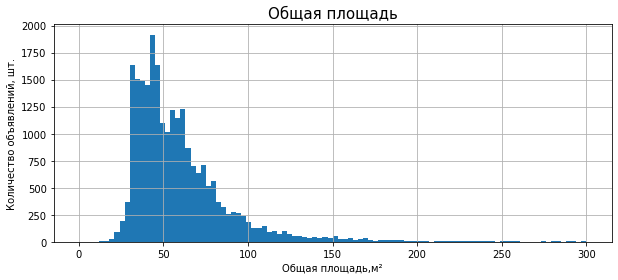

In [47]:
df_check.total_area.hist(range=(0, 300),  bins=100, figsize=( 10 , 4 ) )
plt.title('Общая площадь', fontsize=15)
plt.xlabel('Общая площадь,м²')
plt.ylabel('Количество объявлений, шт.')

По гистограмме total_area можем сделать вывод, что медианное значение находится примерно на 50 м.,кроме этого видим,что есть и 
совсем малые значения total_area менее 15м,что выглядит неправдоподобно.Заменим данные значения на медианные.

In [48]:
data.loc[data['total_area'] < 15, 'total_area'] = data['total_area'].median()


Text(0, 0.5, 'Количество объявлений, шт.')

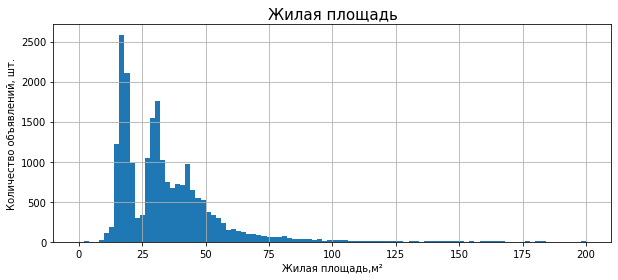

In [49]:
df_check.living_area.hist(range=(0, 200),  bins=100, figsize=( 10 , 4 ) )
plt.title('Жилая площадь', fontsize=15)
plt.xlabel('Жилая площадь,м²')
plt.ylabel('Количество объявлений, шт.')




In [50]:
data.loc[data['living_area'] < 10, 'living_area'] = 10


По гистограмме living_area можем сделать вывод, что медианное значение находится примерно на 30 м.,кроме этого видим,что есть и 
совсем малые значения total_area менее 10м,что выглядит неправдоподобно.Заменим данные значения на 10.

Text(0, 0.5, 'Количество объявлений, шт.')

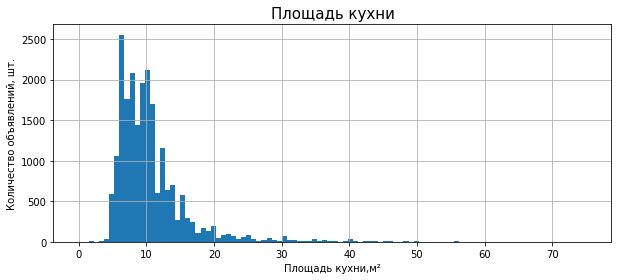

In [51]:
df_check.kitchen_area.hist(range=(0, 75),  bins=100, figsize=( 10 , 4 ) )
plt.title('Площадь кухни', fontsize=15)
plt.xlabel('Площадь кухни,м²')
plt.ylabel('Количество объявлений, шт.')

По гистограмме kitchen_area можем сделать вывод, что медианное значение находится примерно на 9 м.,кроме этого видим,что есть и 
совсем малые значения total_area менее 5м,что выглядит неправдоподобно.Заменим данные значения на 5.

In [52]:
data.loc[data['kitchen_area'] < 5, 'kitchen_area'] = 5


Text(0, 0.5, 'Количество объявлений, шт.')

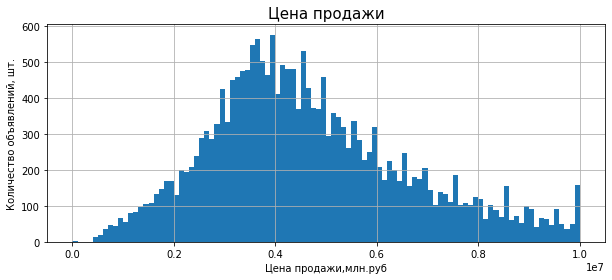

In [53]:
#data.hist('last_price', range=(0, 10000000),  bins=100) #Построим гистограмму по столбцу last_price
df_check.last_price.hist(range=(0, 10000000),  bins=100, figsize=( 10 , 4 ) )
plt.title('Цена продажи', fontsize=15)
plt.xlabel('Цена продажи,млн.руб')
plt.ylabel('Количество объявлений, шт.')

По гистограмме last_price можем сделать вывод, что медианное значение находится примерно на 4 млн.руб,однако есть и 
совсем малые значения last_price,что с одной стороны может говорит о разбросе цен и низкой стоимости недвижимости в сельской
местности,однако объекты со стоимостью до 100тыс.руб выглядят неправдоподобно и данные значения можно удалить из анализа.

In [54]:
data = data[(data['last_price'] > 100000)] 


Text(0, 0.5, 'Количество объявлений, шт.')

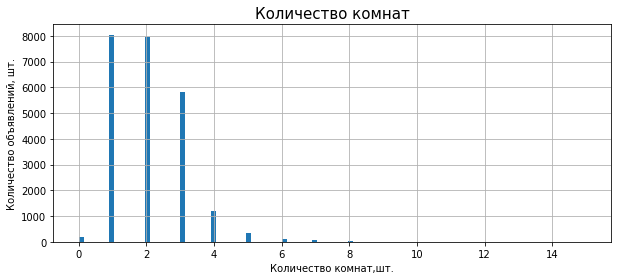

In [55]:
df_check.rooms.hist(range=(0, 15),  bins=100, figsize=( 10 , 4 ) )
plt.title('Количество комнат', fontsize=15)
plt.xlabel('Количество комнат,шт.')
plt.ylabel('Количество объявлений, шт.')

По гистограмме rooms можем сделать вывод, что медианное значение находится примерно на 2 комнатах, данные выглядят нормально,однако,чтобы в этом удостовериться посмотрим еще список уникальных значений столбца rooms.

In [56]:
data['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

Text(0, 0.5, 'Количество объявлений, шт.')

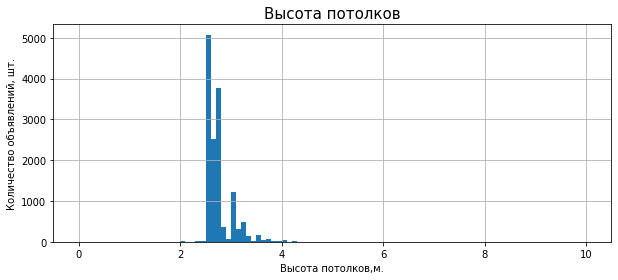

In [57]:
df_check.ceiling_height.hist(range=(0,10),  bins=100, figsize=( 10 , 4 ) )
plt.title('Высота потолков', fontsize=15)
plt.xlabel('Высота потолков,м.')
plt.ylabel('Количество объявлений, шт.')

In [58]:
data['ceiling_height'].unique()

array([  2.7 ,   2.5 ,   3.03,   2.67,   2.56,   3.05,   2.75,   2.6 ,
         2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,   3.25,
         3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,   3.3 ,
         2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,
         3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,   2.58,
         3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,   2.45,
         3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,   3.16,
         3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,   5.  ,
         2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,   2.83,
         4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,   3.18,
         3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,   2.63,
         3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,   3.66,
         3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,   3.36,
        32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,   3.26,
      

По списку уникальных значений столбца ceiling_height видно, данные очень разняться. Поскольку стандартная высота потолков 2,5-3м,но если брать во внимание элитное жилье, двухуровневые квартиры,то возможна высота до 10м. Заменим все выбросы,высоту менее 2 м и более 10 метров медианными значениями ceiling_height.

In [59]:
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data['ceiling_height'].median()
data.loc[data['ceiling_height'] < 2, 'ceiling_height'] = data['ceiling_height'].median()



Text(0, 0.5, 'Количество объявлений, шт.')

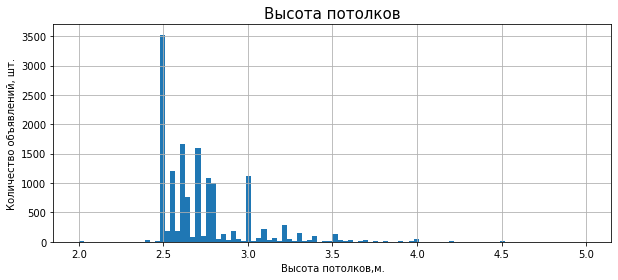

In [60]:
df_check.ceiling_height.hist(range=(2, 5),  bins=100, figsize=( 10 , 4 ) )
plt.title('Высота потолков', fontsize=15)
plt.xlabel('Высота потолков,м.')
plt.ylabel('Количество объявлений, шт.')

Т.к. гистограмму можно построить только по числовым столбцам,то для ее построения по столбцу 
type_floor сделаем преобразования.
Типам первый,другой и последний присвоим значения 1, 2 и 3 соответствено.

In [61]:
data['type_floor'] = data['type_floor'].replace(['первый', 'другой', 'последний'], [1, 2, 3])
data['type_floor'] = pd.to_numeric(data['type_floor'])

array([[<AxesSubplot:title={'center':'type_floor'}>]], dtype=object)

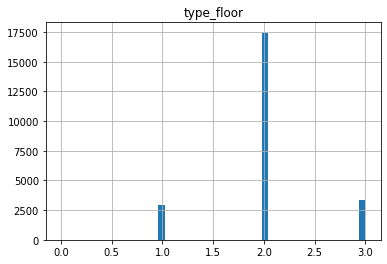

In [62]:
data.hist('type_floor', range=(0,3), bins=50) #построим гистограмму по столбцу type_floor


По данной гистограмме видим довольно правдоподобную картину:большинство объектов рассположено на 'средних' этажах.

In [63]:
data['type_floor'] = data['type_floor'].replace([1, 2, 3], ['первый', 'другой', 'последний'])
#data['type_floor'] = pd.to_numeric(data['type_floor'])

Text(0, 0.5, 'Количество объявлений, шт.')

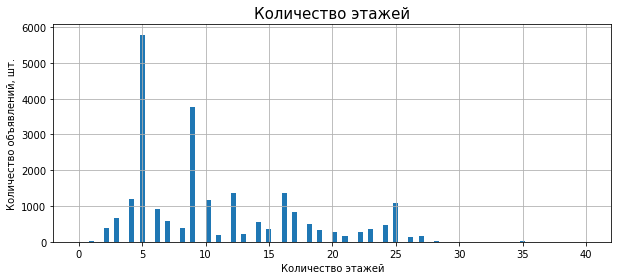

In [64]:
df_check.floors_total.hist(range=(0, 40),  bins=100, figsize=( 10 , 4 ) )
plt.title('Количество этажей', fontsize=15)
plt.xlabel('Количество этажей')
plt.ylabel('Количество объявлений, шт.')

In [65]:
data['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

In [66]:
print(data.query('floors_total == 60'))


      total_images  last_price  total_area first_day_exposition  rooms  \
2253            12   3800000.0        45.5           2018-06-28      2   

      ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
2253            2.88          60.0         27.4      4         False  ...   

      parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
2253          342.0               3.0          614.0            166.0   

     price_m^2  day_week  month  year  type_floor  city_center_km  
2253  83516.48         3      6  2018      другой            49.0  

[1 rows x 28 columns]


In [67]:
data.loc[2253]

total_images                             12
last_price                        3800000.0
total_area                             45.5
first_day_exposition    2018-06-28 00:00:00
rooms                                     2
ceiling_height                         2.88
floors_total                           60.0
living_area                            27.4
floor                                     4
is_apartment                          False
studio                                False
open_plan                             False
kitchen_area                            7.4
balcony                                   0
locality_name                     кронштадт
airports_nearest                    67763.0
cityCenters_nearest                 49488.0
parks_around3000                        2.0
parks_nearest                         342.0
ponds_around3000                        3.0
ponds_nearest                         614.0
days_exposition                       166.0
price_m^2                       

In [68]:
data = data[(data['floors_total'] < 60)] 


По данным гистограммы floors_total: примерно на 5 и 9 этажах,что может говорить об особенностях застройки старого жилого фонда.
Изучив уникальные значение избавляемся от аномального значения 60,т.к. это скорее всего ошибка в данных,т.к. данное здание находится в Кронштадте.

Text(0, 0.5, 'Количество объявлений, шт.')

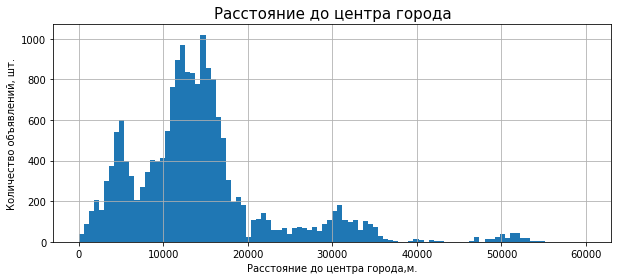

In [69]:
df_check.cityCenters_nearest.hist(range=(0, 60000),  bins=100, figsize=( 10 , 4 ) )
plt.title('Расстояние до центра города', fontsize=15)
plt.xlabel('Расстояние до центра города,м.')
plt.ylabel('Количество объявлений, шт.')

По данным гистограммы cityCenters_nearest видно,что медианное расстояние до центра примерно 15000м, есть также значение 50000м,
что может говорит о том,что это загородная недвижимость и 0м,что говрит о том,что жилой объект нахоодится в центре города.

Text(0, 0.5, 'Количество объявлений, шт.')

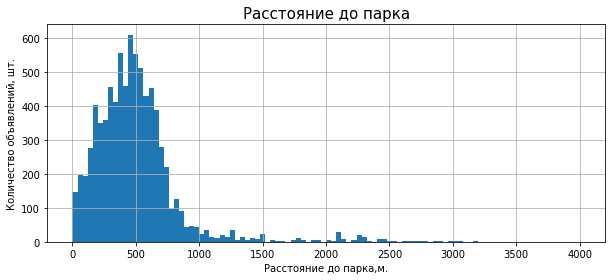

In [70]:
df_check.parks_nearest.hist(range=(0, 4000),  bins=100, figsize=( 10 , 4 ) )
plt.title('Расстояние до парка', fontsize=15)
plt.xlabel('Расстояние до парка,м.')
plt.ylabel('Количество объявлений, шт.')

По гистрограмме parks_nearest можно сделать вывод,что медианное расстояние до парка примерно 500м.

In [71]:
data['parks_nearest'].median()

455.0

#### Проверяем аномалии в полученных значениях

In [72]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23611 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23611 non-null  int64         
 1   last_price            23611 non-null  float64       
 2   total_area            23611 non-null  float64       
 3   first_day_exposition  23611 non-null  datetime64[ns]
 4   rooms                 23611 non-null  int64         
 5   ceiling_height        23611 non-null  float64       
 6   floors_total          23611 non-null  float64       
 7   living_area           21741 non-null  float64       
 8   floor                 23611 non-null  int64         
 9   is_apartment          23611 non-null  bool          
 10  studio                23611 non-null  bool          
 11  open_plan             23611 non-null  bool          
 12  kitchen_area          21380 non-null  float64       
 13  balcony         

In [73]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

( data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
                  'floor', 'floors_total']].apply (['count', 'min', 'max', 'median']).style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,611.00","23,611.00","23,611.00","20,439.00","23,611.00","21,741.00","21,380.00","23,611.00","23,611.00"
min,0.00,15.00,2.00,1.00,"430,000.00",10.00,5.00,1.00,1.00
max,19.00,900.00,8.30,"1,580.00","763,000,000.00",409.70,112.00,33.00,52.00
median,2.00,52.00,2.50,95.00,"4,650,000.00",30.00,9.10,4.00,9.00


In [74]:
 data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
                  'floor', 'floors_total']].apply (['count', 'min', 'max', 'median']).style.format("{:,.2f}")
        

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,611.00","23,611.00","23,611.00","20,439.00","23,611.00","21,741.00","21,380.00","23,611.00","23,611.00"
min,0.00,15.00,2.00,1.00,"430,000.00",10.00,5.00,1.00,1.00
max,19.00,900.00,8.30,"1,580.00","763,000,000.00",409.70,112.00,33.00,52.00
median,2.00,52.00,2.50,95.00,"4,650,000.00",30.00,9.10,4.00,9.00


In [75]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [76]:
# check
df_check.rooms.value_counts().to_frame();

In [77]:
data = data[(data['rooms'] < 8)]
print(len(data))

23580


In [78]:
# check
import matplotlib.pyplot as plt

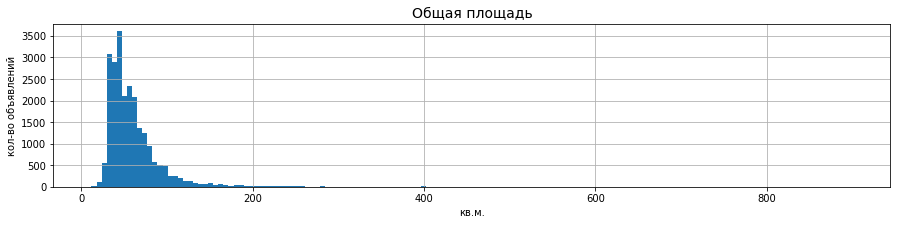

In [79]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3))
plt.title('Общая площадь', fontsize=14)
plt.xlabel('кв.м.')
plt.ylabel('кол-во объявлений');

In [80]:
data = data[(data['total_area'] < 250)]
data = data[(data['total_area'] > 20)]

print(len(data))

23453


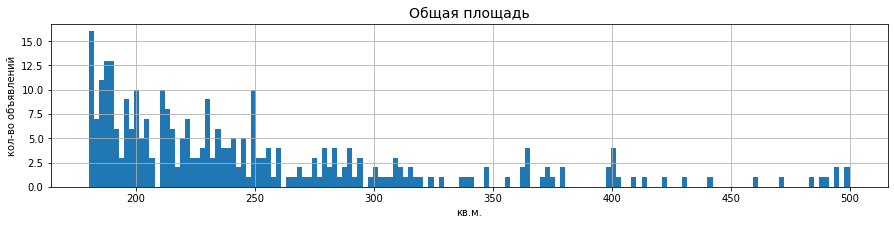

In [81]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500))
plt.title('Общая площадь', fontsize=14)
plt.xlabel('кв.м.')
plt.ylabel('кол-во объявлений');

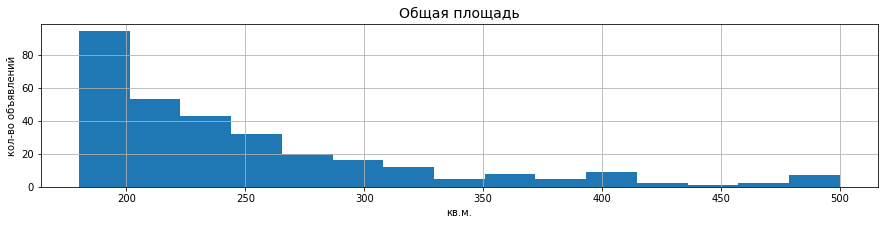

In [82]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500))
plt.title('Общая площадь', fontsize=14)
plt.xlabel('кв.м.')
plt.ylabel('кол-во объявлений');

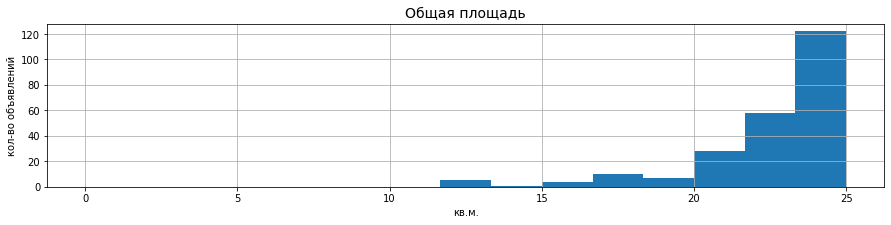

In [83]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25))
plt.title('Общая площадь', fontsize=14)
plt.xlabel('кв.м.')
plt.ylabel('кол-во объявлений');

In [84]:
df_check.ceiling_height.value_counts().to_frame().head(200);

In [85]:
data = data[(data['ceiling_height'] <= 4)]
data = data[(data['ceiling_height'] >= 2)]

print(len(data))

23412


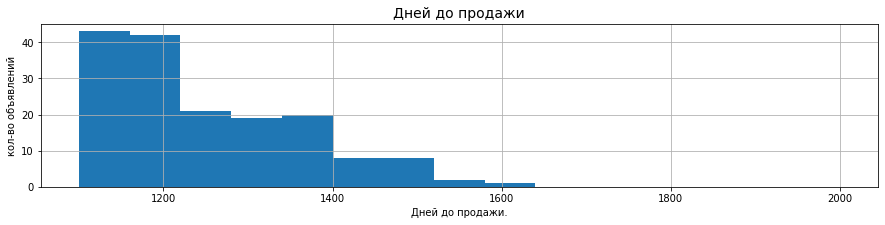

In [86]:
# check
df_check.days_exposition.hist(bins = 15, figsize = (15,3), range = (1100,2000))
plt.title('Дней до продажи', fontsize=14)
plt.xlabel('Дней до продажи.')
plt.ylabel('кол-во объявлений');

In [87]:
#data = data[(data['days_exposition'] <= 1300)]
#print(len(data))

In [88]:
print(len(data))

23412


In [89]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,22.00,2.40,3.00,"580,466.00",10.00,5.00,1.00,2.00
0.01,1.00,26.00,2.50,4.00,"1,000,000.00",13.00,5.00,1.00,2.00
0.5,2.00,52.00,2.50,95.00,"4,600,000.00",30.00,9.02,4.00,9.00
0.99,5.00,170.88,3.50,"1,065.00","29,999,000.00",102.86,33.97,23.00,26.00
0.9988,7.00,230.09,4.00,"1,371.36","76,984,808.40",154.79,53.05,26.00,34.91


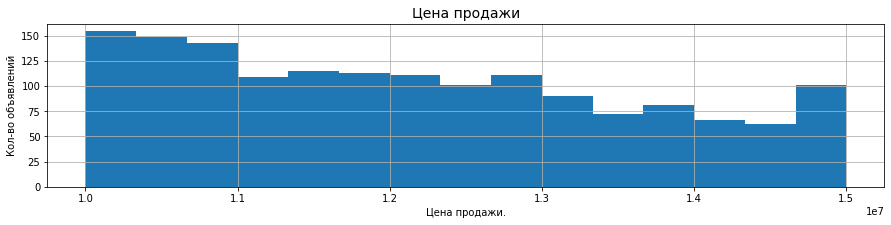

In [90]:
# check
df_check.last_price.hist(bins = 15, figsize = (15,3), range = (10000000,15000000))
plt.title('Цена продажи', fontsize=14)
plt.xlabel('Цена продажи.')
plt.ylabel('Кол-во объявлений');

In [91]:
df_check.last_price.value_counts().to_frame().head(20);

In [92]:
data = data[(data['last_price'] < 50000000)]
data = data[(data['last_price'] > 1000000)]



In [93]:
len(data)

23093

Text(0, 0.5, 'Количество объявлений, шт.')

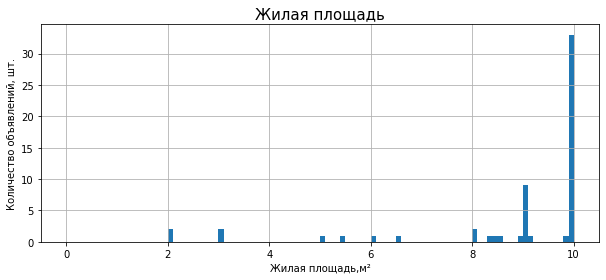

In [94]:
df_check.living_area.hist(range=(0, 10),  bins=100, figsize=( 10 , 4 ) )
plt.title('Жилая площадь', fontsize=15)
plt.xlabel('Жилая площадь,м²')
plt.ylabel('Количество объявлений, шт.')

Text(0, 0.5, 'Количество объявлений, шт.')

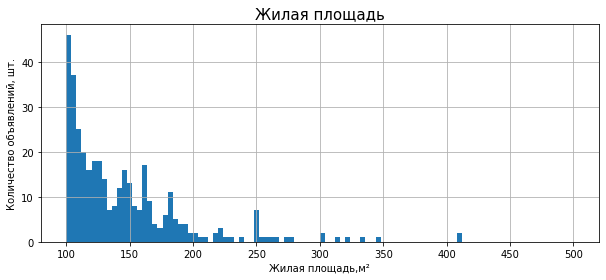

In [95]:
df_check.living_area.hist(range=(100, 500),  bins=100, figsize=( 10 , 4 ) )
plt.title('Жилая площадь', fontsize=15)
plt.xlabel('Жилая площадь,м²')
plt.ylabel('Количество объявлений, шт.')

In [96]:
data = data[(data['living_area'] <= 120)]
data = data[(data['last_price'] >= 10)]

In [97]:
len(data)

21210

Text(0, 0.5, 'Количество объявлений, шт.')

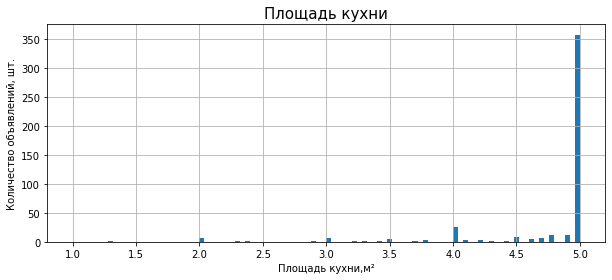

In [98]:
df_check.kitchen_area.hist(range=(1, 5),  bins=100, figsize=( 10 , 4 ) )
plt.title('Площадь кухни', fontsize=15)
plt.xlabel('Площадь кухни,м²')
plt.ylabel('Количество объявлений, шт.')

Text(0, 0.5, 'Количество объявлений, шт.')

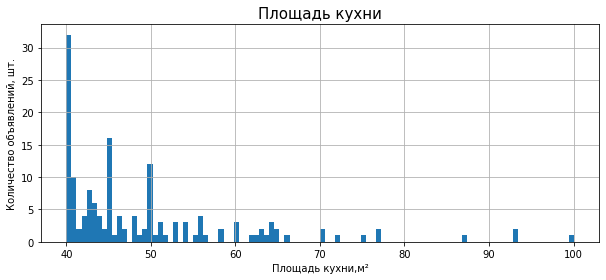

In [99]:
df_check.kitchen_area.hist(range=(40, 100),  bins=100, figsize=( 10 , 4 ) )
plt.title('Площадь кухни', fontsize=15)
plt.xlabel('Площадь кухни,м²')
plt.ylabel('Количество объявлений, шт.')


In [100]:
data = data[(data['kitchen_area'] <= 40)]
data = data[(data['kitchen_area'] >= 5)]

In [101]:
len(data)

20367

In [102]:
df_check.floor.value_counts().to_frame();

In [103]:
data = data[(data['floor'] <= 25)]


In [104]:
len(data)

20332

In [105]:
df_check.floors_total.value_counts().to_frame();

In [106]:
data = data[(data['floors_total'] <= 25)]


In [107]:
len(data)

20062

In [108]:
# check
 
( data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
                  'floor', 'floors_total']].apply (['count', 'min', 'max', 'median']).style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"20,062.00","20,062.00","20,062.00","17,357.00","20,062.00","20,062.00","20,062.00","20,062.00","20,062.00"
min,1.00,20.30,2.00,1.00,"1,010,000.00",10.00,5.00,1.00,1.00
max,7.00,240.00,4.00,"1,580.00","49,900,000.00",120.00,40.00,25.00,25.00
median,2.00,52.00,2.50,101.00,"4,682,500.00",30.00,9.00,4.00,9.00


#### Изучим, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.



Text(0, 0.5, 'Количество объявлений, шт.')

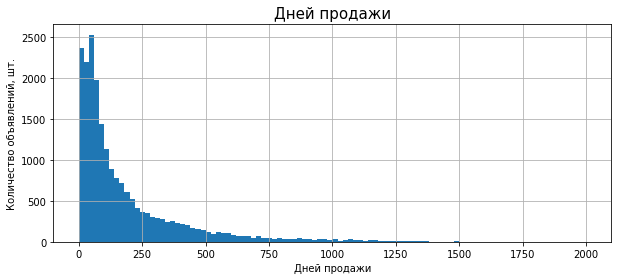

In [109]:
df_check.days_exposition.hist(range=(0, 2000),  bins=100, figsize=( 10 , 4 ) )
plt.title('Дней продажи', fontsize=15)
plt.xlabel('Дней продажи')
plt.ylabel('Количество объявлений, шт.')

Text(0, 0.5, 'Количество объявлений, шт.')

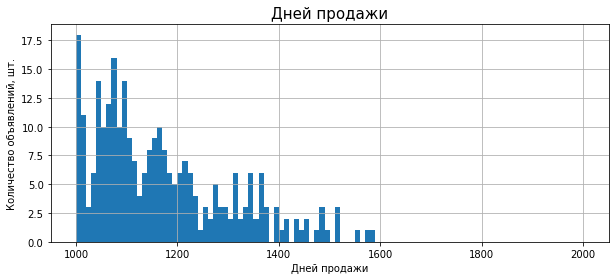

In [110]:
df_check.days_exposition.hist(range=(1000, 2000),  bins=100, figsize=( 10 , 4 ) )
plt.title('Дней продажи', fontsize=15)
plt.xlabel('Дней продажи')
plt.ylabel('Количество объявлений, шт.')

#### check nan

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20062 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20062 non-null  int64         
 1   last_price            20062 non-null  float64       
 2   total_area            20062 non-null  float64       
 3   first_day_exposition  20062 non-null  datetime64[ns]
 4   rooms                 20062 non-null  int64         
 5   ceiling_height        20062 non-null  float64       
 6   floors_total          20062 non-null  float64       
 7   living_area           20062 non-null  float64       
 8   floor                 20062 non-null  int64         
 9   is_apartment          20062 non-null  bool          
 10  studio                20062 non-null  bool          
 11  open_plan             20062 non-null  bool          
 12  kitchen_area          20062 non-null  float64       
 13  balcony         

In [112]:
data = data[(data['days_exposition'] <= 1300)]
print(len(data))

17313


In [113]:
# check
data.shape[0]

17313

Text(0, 0.5, 'Количество объявлений, шт.')

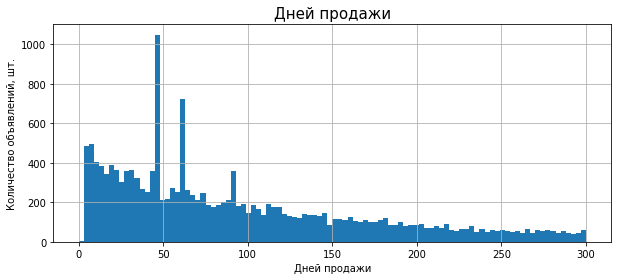

In [114]:
df_check.days_exposition.hist(range=(0, 300),  bins=100, figsize=( 10 , 4 ) )
plt.title('Дней продажи', fontsize=15)
plt.xlabel('Дней продажи')
plt.ylabel('Количество объявлений, шт.')

In [115]:
exp_median = data['days_exposition'].median() #Считаем медианное значение дней продажи объектов
print(exp_median)

100.0


In [116]:
exp_mean = round(data['days_exposition'].mean(), 2) #Считаем среднее значение дней продажи объектов
print(exp_mean)

181.12


    По данным гистограммы и проведенного иследования по столбцу days_exposition можно сделать вывод,что квартиры продавались в среденем 181 дней. Однако медианное значение гораздо меньше и составляет 100 дней.
    Также на гистограмме можно наблюдать пики (моды) на значениях примерно 45 дней, 60 и 90,что скорее всего обусловлено сроками публикации бесплатных объявлений на сайте.

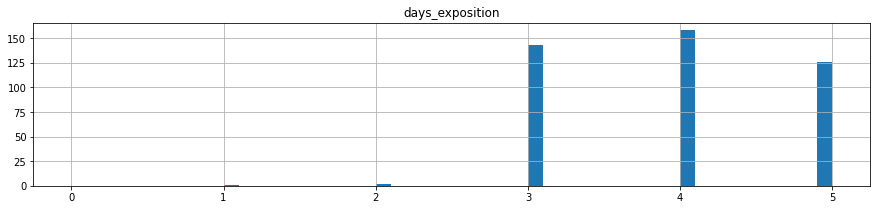

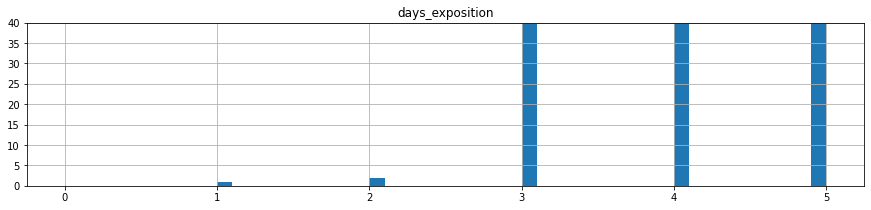

In [117]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

Избавимся от редких значений скорости продаж (days_exposition).

In [118]:
data = data[(data['days_exposition'] >= 3)]  

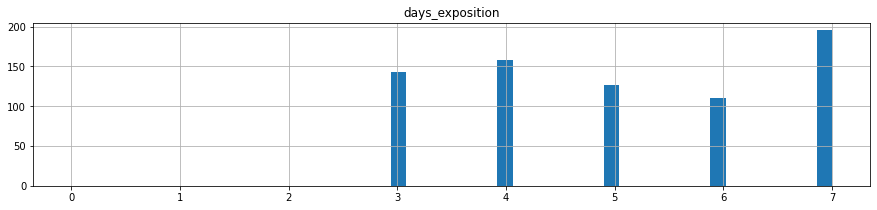

In [119]:
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,7));


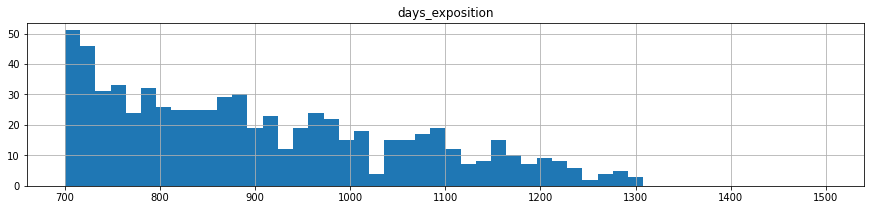

In [120]:
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (700,1500));


In [121]:
data[(data['days_exposition'] >= 700)].count(); 


Таким образом в данном разделе мы избавляемся от аномалий и редкостей по следующим столбцам:
     -rooms,
    -total_area,
    -days_exposition,
    -last_price,
    -loving_area,
    -kitchen_area,
    -floor,
    -floors_total.
    Это необходимо сделать для последующего определения взаимосвязи и корреляции признаков.
    На этапе отсеивания у нас теряется примерно около 5% данных(исходно 23698 строк, после обработки 22516)

   Также была рассчитана скорость продаж days_exposition. В данном столбце у нас наблюдается достаточно много пропущенных значение, что говорит о том, что квартиры еще не проданы и эти показатели пока нельзя взять в расчет,заменить нулями также не представляется возможным,т.к. это исказит картину.Кроме этого наблюдаются редкие значение скорости продаж 1 и 2 дня,которые мы не берм во внимание при проведении анализа.
  Таким образом среднее значение скорости продаж days_exposition составляет 181 день, однако медианное составляет 100 дней.
  Наблюдаются как очень быстрые продажи  до 7 дней (около 750 случаев), так и необычно долгие,более 700 и даже до 1300 дней, около 700 продаж.
  

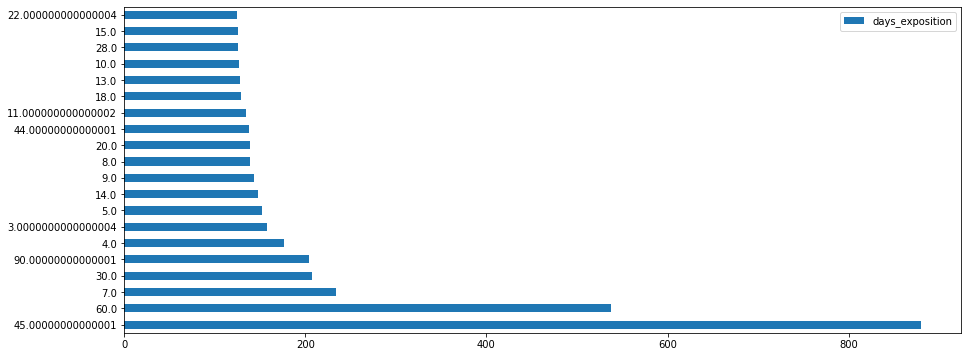

In [122]:
# check
# Моды на сырых данных

try:
    df_check1 = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
except:
    df_check1 = pd.read_csv('real_estate_data.csv', sep='\t')
    
df_check1['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

 ####  Определим какие факторы больше всего влияют на общую (полную) стоимость объекта


Изучим, зависит ли цена от:

    общей площади;
    жилой площади;
    площади кухни;
    количества комнат;
    этажа, на котором расположена квартира (первый, последний, другой);
    даты размещения (день недели, месяц, год).

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

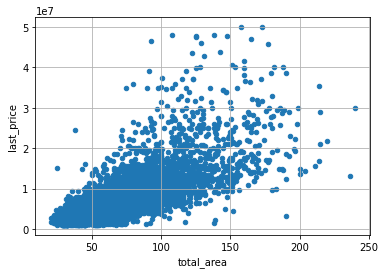

In [123]:
stat_area = (data.pivot_table(index='total_area', values='last_price')) #Построим гистограмму, которая отображает взаимосвязь цены и общей площади
data.plot(x='total_area', y='last_price',  kind='scatter', grid=True)


<AxesSubplot:xlabel='living_area', ylabel='last_price'>

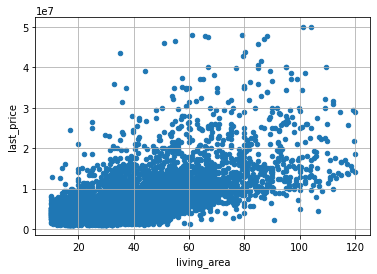

In [124]:
data.plot(x='living_area', y='last_price',  kind='scatter', grid=True) #Построим гистограмму, которая отображает взаимосвязь цены и жилой площади



<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

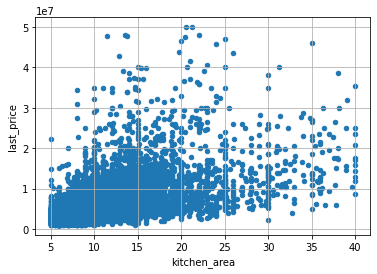

In [125]:
data.plot(x='kitchen_area', y='last_price',  kind='scatter', grid=True) #Построим гистограмму, которая отображает взаимосвязь цены и площади кухни



<AxesSubplot:xlabel='rooms'>

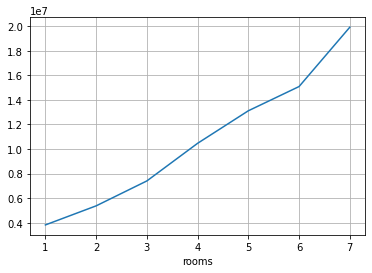

In [126]:
data.groupby(['rooms'])['last_price'].mean().plot(style='-', grid=True)

<AxesSubplot:xlabel='type_floor'>

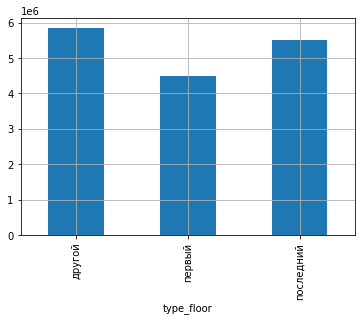

In [127]:
data.groupby(['type_floor'])['last_price'].mean().plot.bar(style='-', grid=True)


По данным гистограммы и значению коэффициента корреляции Пирсона видим что особой взаимосвязи  между типом этажа и ценой квартиры нет.

<AxesSubplot:xlabel='month'>

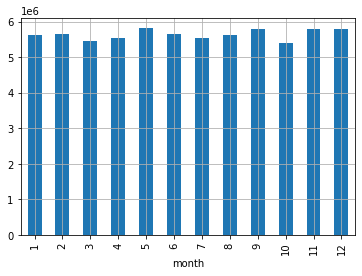

In [129]:
data.groupby(['month'])['last_price'].mean().plot.bar(style='-', grid=True)



In [130]:
data_pivot = data.pivot_table(index='locality_name', values=['last_price','total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height', 'type_floor', 'floors_total'])
print(data_pivot)

               ceiling_height  floors_total  kitchen_area    last_price  \
locality_name                                                             
unknown              2.678919      9.459459     11.594054  6.856355e+06   
волосово             2.518333      4.566667      7.807000  1.917000e+06   
волхов               2.552462      4.907692      7.465077  1.670462e+06   
всеволожск           2.607559      8.545151     10.161906  3.700406e+06   
выборг               2.577152      5.867089      8.034367  3.047367e+06   
...                       ...           ...           ...           ...   
сосновый бор         2.558364      8.472727      8.534545  4.030132e+06   
сясьстрой            2.564286      4.571429      7.428571  1.820000e+06   
тихвин               2.535172      7.275862      8.088621  1.860690e+06   
тосно                2.525732      7.451220      8.907683  3.116524e+06   
шлиссельбург         2.569048      7.142857      8.763571  2.936762e+06   

               living_ar

In [131]:
data_pivot.corr()
#data_pivot.style.background_gradient(cmap='coolwarm')

,ceiling_height,floors_total,kitchen_area,last_price,living_area,rooms,total_area
ceiling_height,1.000000,-0.016056,0.362082,0.303352,0.225569,0.064141,0.354404
floors_total,-0.016056,1.000000,0.217807,0.437886,-0.085685,-0.124075,0.015109
kitchen_area,0.362082,0.217807,1.000000,0.475203,0.115292,0.024126,0.530848
last_price,0.303352,0.437886,0.475203,1.000000,0.161006,0.040185,0.350214
living_area,0.225569,-0.085685,0.115292,0.161006,1.000000,0.901972,0.870711
rooms,0.064141,-0.124075,0.024126,0.040185,0.901972,1.000000,0.768962
total_area,0.354404,0.015109,0.530848,0.350214,0.870711,0.768962,1.000000


year
2014    9.227988e+06
2015    6.336146e+06
2016    5.849624e+06
2017    5.636410e+06
2018    5.436337e+06
2019    5.413732e+06
Name: last_price, dtype: float64


Text(0, 0.5, 'Цена квартиры')

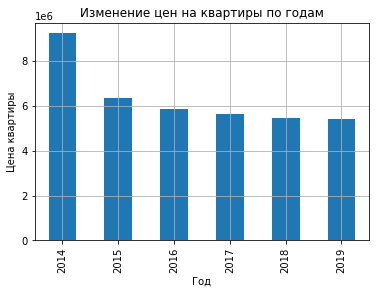

In [132]:
data_pivot_year=data.groupby('year')['last_price'].mean()
#pivot_table(index='locality_name', values=['last_price','year', 'living_area'], aggfunc='mean')
print(data_pivot_year)
data_pivot_year.plot.bar(grid=True)
plt.title('Изменение цен на квартиры по годам', fontsize=12)
plt.xlabel('Год')
plt.ylabel('Цена квартиры')

year
2014    76.586923
2015    63.907468
2016    59.523880
2017    57.433239
2018    54.872338
2019    51.456045
Name: total_area, dtype: float64

Text(0, 0.5, 'Общая площадь,кв.м')

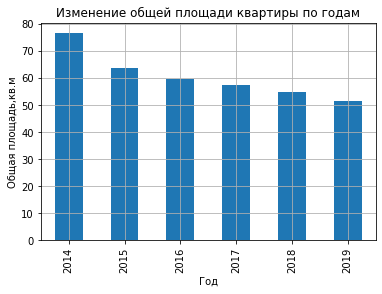

In [133]:
data_pivot2 = data.groupby('year')['total_area'].mean()
display(data_pivot2)
data_pivot2.plot.bar(grid=True)
plt.title('Изменение общей площади квартиры по годам', fontsize=12)
plt.xlabel('Год')
plt.ylabel('Общая площадь,кв.м')

In [ ]:
data_pivot3 = data.groupby('year')['last_price'].count()
display(data_pivot3)
data_pivot3.plot.bar(grid=True)
plt.title('Изменение количества объявлений по годам', fontsize=12)
plt.xlabel('Год')
plt.ylabel('Количество объявлений,шт.')

Таким образом, оценив динамику цен с 2014 по 2019 год в разрезе данного исследования,можно сделать  выводы.
    Средняя цена за квартиру по годам с 2014 по 2019 имела тенденцию резкого снижения в 2015 г.и далее держалась примерно, на одном уровне с уклоном на небольшой спад. Однако это не говорит о том,что квартиры дешевеют, т.к. при рассмотрении в разрезе таких показателей как общая площадь квартиры, мы видим что данный показатель также снижался и наибольшее его снижение было также в 2015 г/, а из расчетов выше можно отметить что эти 2 показателя(цена и общая площадь) имеют положительную корреляцию.
    Кроме это проведенное сравнение по годам нельзя считать полностью корректным,т.к. объемы данных(объявлений о продаже) очень разнятся из года в год и сравнивая данные 91 объявления о продаже за 2014г и 6856 за 2017г. мы не можем сделать достоверные выводы, о том, что цены на недвижимость падают.

Рассчитаем среднюю цену  одного квадратного метра

In [135]:
print(data['price_m^2'].sort_values(ascending=False).mean()) 

96527.74515771231


Группируем датафрейм по населенным пунктам с наибольшим количеством объявлений и средней ценой квадратного метра по населенному пункту


In [136]:
stat=data.pivot_table(index='locality_name', values='price_m^2', aggfunc=['count', 'mean']) 
top = round(stat.sort_values(by=[('count', 'price_m^2' )], ascending=False), 2).head(10)
print(top)


                      count       mean
                  price_m^2  price_m^2
locality_name                         
санкт-петербург       11759  108883.92
поселок шушары          361   78022.99
мурино                  356   85574.51
кудрово                 345   94219.02
всеволожск              299   68943.95
колпино                 291   74507.58
пушкин                  267  101823.83
гатчина                 250   67972.63
петергоф                168   83097.19
поселок парголово       164   86106.71


Text(0, 0.5, 'Цена.')

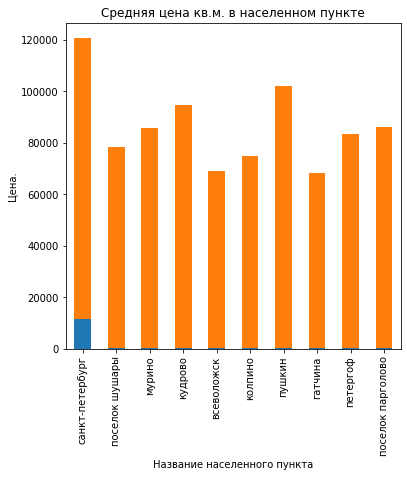

In [137]:
top.plot.bar(stacked= True, figsize=(6, 6), legend = False) 
plt.title('Средняя цена кв.м. в населенном пункте', fontsize=12)
plt.xlabel('Название населенного пункта')
plt.ylabel('Цена.')

 В данном разделе были изучены зависимости цены обьекта недвижимости от следующих параметров:
-общей площади
-жилой площади
-площади кухни
-высоты потолков
-количества этажей
-количества комнат
-типа этажа,на котором находится объект.
  Выявили положительную корреляцию между ценой и общей площадью,ценой и площадью кухни,ценой и количеством комнат.
Также определили ТОП 10 населенных пунктов с наибольшим количеством объявлений.


locality_name    city_center_km
санкт-петербург  0.0               1.311855e+07
                 1.0               1.189240e+07
                 2.0               1.102651e+07
                 3.0               9.018346e+06
                 4.0               9.871542e+06
                 5.0               1.024996e+07
                 6.0               1.061604e+07
                 7.0               1.014204e+07
                 8.0               8.433152e+06
                 9.0               6.597990e+06
                 10.0              5.931712e+06
                 11.0              5.803370e+06
                 12.0              5.627575e+06
                 13.0              5.847585e+06
                 14.0              5.421825e+06
                 15.0              5.465044e+06
                 16.0              5.132887e+06
                 17.0              5.111524e+06
                 18.0              4.922523e+06
                 19.0              5.066922e+06
        

<AxesSubplot:xlabel='city_center_km'>

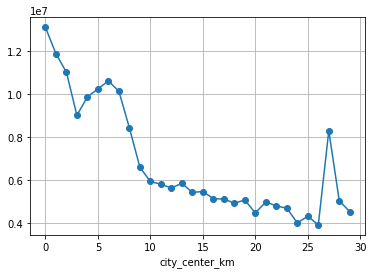

In [138]:
dataS=(data[data['locality_name'] == 'санкт-петербург']) 
print(dataS.groupby(['locality_name', 'city_center_km'])['last_price'].mean())
dataS.groupby(['city_center_km'])['last_price'].mean().plot(style='o-', grid=True)

По графику выше,можно сделать вывод,что самая высокая цента квадратного метра в центре города, далее цена снижается,до расстояния 3-х км., а потом опять возрастает в точке примерно 7км, далее цена идет на спад и имеет еще один крупный скачек на расстоянии примерно 27 км от центра.

In [139]:
data_3km = data.query('city_center_km == 3 & locality_name == "санкт-петербург"')
display(data_3km)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m^2,day_week,month,year,type_floor,city_center_km
99,32,9600000.0,90.0,2017-09-26,4,2.50,5.0,67.0,2,False,...,NaN,0.0,NaN,104.0,106666.67,1,9,2017,другой,3.0
138,8,4800000.0,40.0,2017-11-18,2,2.50,3.0,29.0,2,False,...,NaN,2.0,729.0,80.0,120000.00,5,11,2017,другой,3.0
201,5,10880000.0,123.1,2015-11-12,6,3.20,5.0,89.0,2,False,...,516.0,0.0,NaN,992.0,88383.43,3,11,2015,другой,3.0
316,11,5650000.0,46.3,2017-03-13,2,2.50,6.0,28.8,2,False,...,NaN,0.0,NaN,89.0,122030.24,0,3,2017,другой,3.0
404,2,11400000.0,81.2,2016-04-27,3,2.50,3.0,45.7,2,False,...,NaN,3.0,611.0,89.0,140394.09,2,4,2016,другой,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23176,2,6800000.0,69.2,2017-11-14,3,2.90,5.0,39.9,4,False,...,436.0,1.0,666.0,447.0,98265.90,1,11,2017,другой,3.0
23178,7,5950000.0,60.0,2018-02-01,3,2.80,5.0,42.0,1,False,...,NaN,0.0,NaN,85.0,99166.67,3,2,2018,первый,3.0
23387,7,5600000.0,50.0,2017-08-21,1,2.50,5.0,27.0,1,False,...,394.0,3.0,56.0,45.0,112000.00,0,8,2017,первый,3.0
23430,18,5260000.0,38.0,2018-11-06,1,3.30,5.0,16.0,1,False,...,538.0,1.0,466.0,12.0,138421.05,1,11,2018,первый,3.0


In [140]:
data_3km_group=data_3km.groupby(['locality_name', 'city_center_km', 'type_floor'])['last_price'].count()
display(data_3km_group)

locality_name    city_center_km  type_floor
санкт-петербург  3.0             другой        134
                                 первый         41
                                 последний      59
Name: last_price, dtype: int64

<AxesSubplot:ylabel='last_price'>

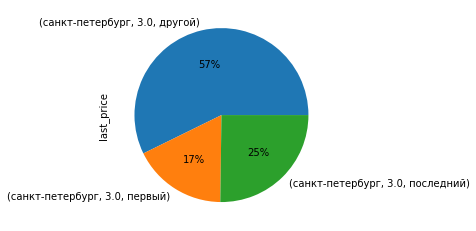

In [141]:
data_3km_group.plot(kind='pie', autopct='%i%%')

In [142]:
data_5km =data.query('city_center_km == 5 & locality_name == "санкт-петербург"')
display(data_5km)



,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m^2,day_week,month,year,type_floor,city_center_km
63,2,20000000.0,118.0,2018-09-11,3,3.00,9.0,68.0,7,False,...,648.0,1.0,779.0,37.0,169491.53,1,9,2018,другой,5.0
159,14,7050000.0,66.0,2017-09-04,3,3.00,4.0,37.8,4,False,...,NaN,1.0,1013.0,98.0,106818.18,0,9,2017,последний,5.0
219,12,7700000.0,58.7,2017-12-12,1,2.50,7.0,17.0,3,False,...,239.0,0.0,NaN,136.0,131175.47,1,12,2017,другой,5.0
318,12,9990000.0,67.0,2017-07-10,1,2.84,9.0,37.0,7,False,...,741.0,1.0,713.0,50.0,149104.48,0,7,2017,другой,5.0
320,2,12734000.0,97.0,2016-01-30,3,2.50,10.0,51.2,7,False,...,NaN,1.0,874.0,195.0,131278.35,5,1,2016,другой,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23536,8,6080000.0,70.0,2018-10-12,3,2.50,4.0,44.4,4,False,...,291.0,0.0,NaN,69.0,86857.14,4,10,2018,последний,5.0
23549,5,19600000.0,184.0,2016-04-21,3,3.00,19.0,55.7,19,False,...,NaN,0.0,NaN,205.0,106521.74,3,4,2016,последний,5.0
23559,20,13800000.0,108.6,2016-09-12,3,2.50,19.0,70.6,7,False,...,NaN,1.0,503.0,354.0,127071.82,0,9,2016,другой,5.0
23664,5,9000000.0,110.0,2015-12-10,4,3.36,7.0,64.6,5,False,...,417.0,1.0,118.0,816.0,81818.18,3,12,2015,другой,5.0


locality_name    city_center_km  type_floor
санкт-петербург  5.0             другой        487
                                 первый         54
                                 последний      89
Name: last_price, dtype: int64


<AxesSubplot:ylabel='last_price'>

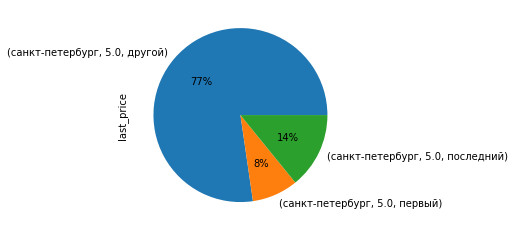

In [143]:
data_5km_group=data_5km.groupby(['locality_name', 'city_center_km', 'type_floor'])['last_price'].count()
print(data_5km_group)
data_5km_group.plot(kind='pie', autopct='%i%%')

Оценив количество квартир,продающихся на 3км. и 5км.от центра Санкт-Петербурга можем сделать выводы,что
объявлений на 5км больше практически в 3 раза и если рассматривать в разрезе типа этажей,то 77% квартир продаются на средних этаж, тогда как на 3 км.только 57% продается на средних этажах,а квартиры на первых с последних этажах,как правило, ниже в цене, что может повлиять на среднее значение цены на данном километре.

In [144]:
data.query('city_center_km == 27 & locality_name == "санкт-петербург"')


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m^2,day_week,month,year,type_floor,city_center_km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5.0,30.0,3,False,...,1496.0,0.0,NaN,128.0,193918.92,1,11,2017,другой,27.0
5961,6,2250000.0,32.0,2018-02-27,1,2.50,2.0,16.5,2,False,...,NaN,0.0,NaN,178.0,70312.50,1,2,2018,последний,27.0


Выброс в данных на 27км обусловлен тем,что там находятся только 2 квартиры и одна из них с высокой ценой(14350000),что и дает нам аномально высокое среднее значение для данного рассположения.

### Напишите общий вывод

    В ходе исследования были оценены данные по продаже квартир в Санкт-Петербурге и области и устранены следующие неточности в данных:
    -были изменены типы данных в столбцах в соответствии тем, что эти данные должны отображать,
    -были заполнены пропуски в тех столбцах,где это уместно, а также ,а также пропуски в названиях заменены на unknown.
    Также были выявлены и замены неявные дубликаты в названиях. Была рассчитана средняя площадь метра квадратного, а также выявлены 10 городов с наиибольшим количеством объявлений и наиболее высокой ценой квадратного метра.
    Была рассмотрена зависимость цены от других параметров с помощью гистограмм и коэффициентов корреляции. что наибольшая положительная линейная взаимосвязь между общей площадью и ценой и жилой площадью и ценой.
     Была исследована динамика цен по годам.Средняя цена за квартиру по годам с 2014 по 2019 имела тенденцию резкого снижения в 2015 г.и далее держалась примерно, на одном уровне с уклоном на небольшой спад. Однако это не говорит о том,что квартиры дешевеют, т.к. при рассмотрении в разрезе таких показателей как общая площадь квартиры, мы видим что данный показатель также снижался и наибольшее его снижение было также в 2015 г/, а из расчетов выше можно отметить что эти 2 показателя(цена и общая площадь) имеют положительную корреляцию.
    Кроме это проведенное сравнение по годам нельзя считать полностью корректным,т.к. объемы данных(объявлений о продаже) очень разнятся из года в год и сравнивая данные 91 объявления о продаже за 2014г и 6856 за 2017г. мы не можем сделать достоверные выводы, о том, что цены на недвижимость падают.
    Была рассчитана средняя стоимость квартир в Санк-Петеребурге,в зависимости от удаленности от центра города.Самая высокая цента квадратного метра в центре города, далее цена снижается,до расстояния 3-х км., а потом опять возрастает в точке примерно 7км, далее цена идет на спад и имеет еще один крупный скачек на расстоянии примерно 27 км от центра, что обусловлено тем,что там находятся только 2 квартиры и одна из них с высокой ценой(14350000),что и дает нам аномально высокое среднее значение для данного рассположения.
